# IMDB Review Sentiment Prediction

This project consists of a total of 50,000 movie reviews labeled either positive or negative. The steps leading up to the training of the model include: data importation, pre-processing, exploration and visualization. Finally, I will define and train a Keras deep learning model architecture on 25,000 training documents. The DL model will attempt to predict whether a movie review is positive or negative from the text found in the review. The deep learning model created will be tested on the other unseen 25,000 labeled movie reviews, and we will record its performance. Data used in this project can be found [here](https://ai.stanford.edu/~amaas/data/sentiment/), courtesy of Stanford University.

In [1]:
# import necessary libraries
import operator
import collections as coll
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stat
import math
import os
import re
from keras.preprocessing.text import Tokenizer, one_hot

Using TensorFlow backend.


In [2]:
# define function to retrive all data
def get_reviews(data_path):
    # initialize empty train/test reviews (text) and labels (positive/negative)
    train_reviews = []
    test_reviews = []
    train_labels = []
    test_labels = []
    # loop both train/test folders
    for dataset in ['train', 'test']:
        # loop over positive and negative review folders
        for feedback in ['pos', 'neg']:
            # create path for folder currently in
            reviews_folder = os.path.join(data_path, dataset, feedback)
            # loop over each review one at a time
            for review_file_name in sorted(os.listdir(reviews_folder)):
                # import only text files containing corresponding review text
                if review_file_name.endswith('.txt'):
                    # create path to review file and open as review
                    with open(os.path.join(reviews_folder, review_file_name)) as review:
                        # append train review text and labels
                        if dataset == 'train':
                            # read into appropriate folder
                            train_reviews.append(review.read())
                            # append training labels positive, 1, negative, 0. 
                            if feedback == 'pos':
                                train_labels.append(1)
                            else:
                                train_labels.append(0)  
                        # append test set reviews and labels 
                        else:
                            test_reviews.append(review.read())
                            if feedback == 'pos':
                                test_labels.append(1)  
                            else:
                                test_labels.append(0)
                            
                        
                        
    # turn lists into numpy arrays due to large sized data
    # arrays more compact and efficient at handlind large amt of data
    train_reviews = np.array(train_reviews)
    test_revies = np.array(test_reviews)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    return train_reviews, test_reviews, train_labels, test_labels

In [3]:
data_path = os.path.expanduser('~/Desktop/IMDB_Reviews/data')
# import data
train, test, train_label, test_label = get_reviews(data_path)

In [4]:
# check lengths of train and test set
print('Train Set Length:\t', len(train))
print('Test Set Length:\t', len(test))
print('Train Label Length:\t', len(train_label))
print('Test Label Length:\t', len(test_label))

Train Set Length:	 25000
Test Set Length:	 25000
Train Label Length:	 25000
Test Label Length:	 25000


In [5]:
# check train and test label possible values
print('Possible Train Labels:\t', np.unique(train_label))
print('Possible Test Labels:\t', np.unique(test_label))

Possible Train Labels:	 [0 1]
Possible Test Labels:	 [0 1]


In [6]:
# how many unique words in sets
print('Training Unique Words:\t', len(np.unique(' '.join(train).split())))
print('Testing Unique Words:\t', len(np.unique(' '.join(test).split())))

Training Unique Words:	 280617
Testing Unique Words:	 276678


In [7]:
# average number of words per review
train_words = []
test_words = []
for review in train:
    train_words.append(len(review.split()))
for review in test:
    test_words.append(len(review.split()))
print('Average # Words in Training:\t', math.trunc(stat.mean(train_words)))
print('Average # Words in Testing:\t', math.trunc(stat.mean(test_words)))

Average # Words in Training:	 233
Average # Words in Testing:	 228


## Preprocess Data

### *1. Remove Regular Expressions*

In [8]:
print('Example Review Before Regular Expressions Performed:\n\n', train[1])

Example Review Before Regular Expressions Performed:

 Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see i

In [9]:
# define regular expressions function to remove zero-information punctuation, capitalization and other
def remove_punctuation_and_other(reviews):
    # remove punctuation and capitalization
    reviews = [re.compile("[.;:!\'?,\"()\[\]]").sub('', review.lower()) for review in reviews]
    # remove other zero-info values
    remove_other = [re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)").sub(' ', review) for review in reviews]
    # return processed reviews (remove_other)
    return remove_other
    

In [10]:
# apply regex function to reviews
train_re = remove_punctuation_and_other(train)
test_re = remove_punctuation_and_other(test)

In [11]:
# display same review after removal of punctuation, capitalization and other
print('Same Review After Regular Expressions Function Applied:\n\n', train_re[1])

Same Review After Regular Expressions Function Applied:

 homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter most people think of the homeless as just a lost cause while worrying about things such as racism the war on iraq pressuring kids to succeed technology the elections inflation or worrying if theyll be next to end up on the streets but what if you were given a bet to live on the streets for a month without the luxuries you once had from a home the entertainment sets a bathroom pictures on the wall a computer and everything you once treasure to see what its like to be homeless that is goddard bolts lesson mel brooks who directs who stars as bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival jeffery tambor to see if he can live in the streets for thirty days 

### *2. Remove Stop Words*

In [12]:
# define remove stop words (ex: the, i, it...) function
stop_words = set(stopwords.words('english'))
def one_review(review):
    review = [word for word in review.split() if word not in stop_words] 
    review = ' '.join(review)
    return review
def remove_stop(reviews):
    reviews = [one_review(review) for review in reviews]
    return reviews

In [13]:
# apply remove stop words function
train_stop = remove_stop(train_re)
test_stop = remove_stop(test_re)

In [14]:
print('Same review after removal of stop words:\n\n', train_stop[1])

Same review after removal of stop words:

 homelessness houselessness george carlin stated issue years never plan help street considered human everything going school work vote matter people think homeless lost cause worrying things racism war iraq pressuring kids succeed technology elections inflation worrying theyll next end streets given bet live streets month without luxuries home entertainment sets bathroom pictures wall computer everything treasure see like homeless goddard bolts lesson mel brooks directs stars bolt plays rich man everything world deciding make bet sissy rival jeffery tambor see live streets thirty days without luxuries bolt succeeds wants future project making buildings bets bolt thrown street bracelet leg monitor every move cant step sidewalk hes given nickname pepto vagrant written forehead bolt meets characters including woman name molly lesley ann warren ex dancer got divorce losing home pals sailor howard morris fumes teddy wilson already used streets theyr

### *3. Remove Uncommon Words*

In [15]:
# initialize tokenizer and train on training set
# allow for one hot encoding
t = Tokenizer()
t.fit_on_texts(train_stop)

In [16]:
print('Top Ten Used Words Before Uncommon Word Removal:')
sorted(t.word_counts.items(), key=operator.itemgetter(1), reverse=True)[:10]

Top Ten Used Words Before Uncommon Word Removal:


[('movie', 43251),
 ('film', 38921),
 ('one', 26399),
 ('like', 20182),
 ('good', 15031),
 ('time', 12615),
 ('even', 12570),
 ('would', 12229),
 ('story', 11879),
 ('really', 11706)]

In [17]:
# create a list of words that appear less than 100 times in 25,000 training reviews
less_than100 = []
for word, counts in t.word_counts.items():
    if counts < 100:
        less_than100.append(word)
# also add to less_than100 'movie' and 'film' since they are
# top 2 most frequent words, but add no sentiment value
less_than100.extend(('movie', 'film'))
# create set from list for faster membership test of words
less_than100 = set(less_than100)

In [18]:
# define function that will remove less_than100 words from training data
def uncommon_one(review):
    review = [word for word in review.split() if word not in less_than100] 
    review = ' '.join(review)
    return review
def remove_uncommon(reviews):
    reviews = [uncommon_one(review) for review in reviews]
    return reviews

In [19]:
# apply remove_uncommon function to training data
train_clean = remove_uncommon(train_stop)
test_clean = remove_uncommon(test_stop)

In [20]:
print('Same Review After Uncommon Word Removal:\n\n', train_clean[1])

Same Review After Uncommon Word Removal:

 george stated issue years never plan help street considered human everything going school work vote matter people think homeless lost cause things racism war kids succeed technology theyll next end streets given bet live streets month without home entertainment sets bathroom pictures wall computer everything treasure see like homeless lesson mel brooks directs stars plays rich man everything world make bet rival see live streets thirty days without succeeds wants future project making thrown street leg every move cant step hes given written meets characters including woman name ann warren ex dancer got divorce losing home howard wilson already used streets theyre survivors isnt hes used like rich fight flight kill killed love connection wasnt necessary plot found life one mel brooks films prior comedy shows tender side compared slapstick work young matter show like something losing next day hand making stupid bet like rich people dont know mon

In [21]:
print('Unique Words Before Uncommon Words Removed: ', len(np.unique(' '.join(train_stop).split())))
print('Unique Words After Uncommon Words Removed:  ', len(np.unique(' '.join(train_clean).split())))

Unique Words Before Uncommon Words Removed:  95350
Unique Words After Uncommon Words Removed:   6690


### 4. *One-Hot Encoding*

In [22]:
# one hot encode train and test data in order to be able to input into deep learning model
# each word replaced by integer representing word index
vocab_size = 6690
encoded_train = [one_hot(review, vocab_size) for review in train_clean]
encoded_test = [one_hot(review, vocab_size) for review in test_clean]

## Data Exploration and Visualization

### *All Data*

#### *1. Review Lengths (after preprocessing steps)*

Longest Reviews:	 [880, 727, 701, 689, 598, 587, 584, 577, 560, 560, 559, 553, 521, 500] 

Average Review Length:	 94.19736 

Median Review Length:	 71.0 



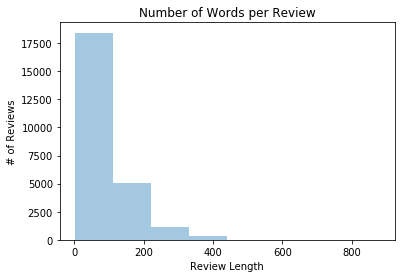

In [106]:
# check max review length
review_lengths = []
for review in encoded_train:
    review_lengths.append(len(review))
print('Longest Reviews:\t', sorted(review_lengths, reverse=True)[:14], '\n')
print('Average Review Length:\t', stat.mean(review_lengths), '\n')
print('Median Review Length:\t', stat.median(review_lengths), '\n')

# review length after preprocessing
ax = sns.distplot(review_lengths, bins=8, kde=False)
ax.set(xlabel='Review Length', ylabel='# of Reviews', title='Number of Words per Review')
plt.show()

From the plot above, we can see that the majority of reviews are below 100 words in length.

#### *2. Most Frequently Used Words*
Words will be counted for every time it is used in a given review; for example, if a word is used 5 times in a given review, all 5 instanecs will be counted.

In [25]:
# tokenize clean dataset
# allows for quick word counts
freq = Tokenizer()
freq.fit_on_texts(train_clean)

Most Frequently Used Words:
('one', 26399)
('like', 20182)
('good', 15031)
('time', 12615)
('even', 12570)
('would', 12229)
('story', 11879)
('really', 11706)
('see', 11431)
('well', 10529)


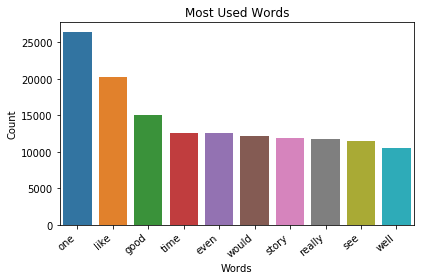

In [26]:
# top 10 words used
word_counts = sorted(freq.word_counts.items(), key=operator.itemgetter(1), reverse=True)[:10]
print('Most Frequently Used Words:')
for i in range(10):
    print(word_counts[i])
    
# top 10 word counts bar chart
words_plt = []
counts_plt = []
for word, count in word_counts:
    words_plt.append(word)
    counts_plt.append(count)
count_bar = sns.barplot(words_plt, counts_plt)
count_bar.set_title('Most Used Words')
count_bar.set(xlabel = 'Words', ylabel = 'Count')
count_bar.set_xticklabels(count_bar.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### *3. Most Frequently Used Words per Review*
Words will be counted only once per review; for example, if a word is used 5 times in a given review, only 1 instance will be counted. This will allow for us to see if the most frequenly used words appear in many reviews, or if some words are used repeatedly in reviews.

Most Frequently Used Words:
('one', 14061)
('like', 11640)
('good', 9600)
('time', 8677)
('even', 8374)
('see', 8069)
('would', 8039)
('really', 7618)
('story', 7575)
('well', 7443)


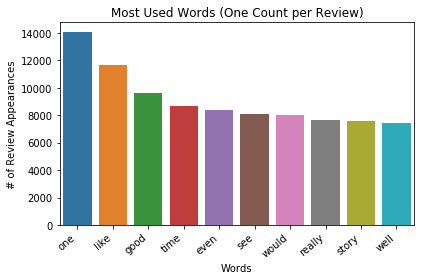

In [27]:
# most used words counting only one instance per review
word_docs_counts = sorted(freq.word_docs.items(), key=operator.itemgetter(1), reverse=True)[:10]
print('Most Frequently Used Words:')
for i in range(10):
    print(word_docs_counts[i])
    
# top 10 word counts bar chart
words_docs_plt = []
counts_docs_plt = []
for word, count in word_docs_counts:
    words_docs_plt.append(word)
    counts_docs_plt.append(count)
count_docs_bar = sns.barplot(words_docs_plt, counts_docs_plt)
count_docs_bar.set_title('Most Used Words (One Count per Review)')
count_docs_bar.set(xlabel = 'Words', ylabel = '# of Review Appearances')
count_docs_bar.set_xticklabels(count_docs_bar.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

From comparing the above two methods of counting words in the training dataset we can see that the most used words in both are the same, but the order of some words change. Also, it can be noted that the most used words do add sentiment value, but more context is needed for the deep learning model to classify correctly. For example, the word "really" is the eight most used word in the training dataset, but that does not give info as to how it was used in the review. The word "really" could have been used in a review either as "i really like this movie" or as "this movie really sucks"; both reviews use the word "really" but contain a completely oppositive sentiment towards the movie being reviewed. In order to account for this, we will use Kera's embedding layer, which takes into account the position of words relative to one another, or in other words the context of the words being used.

### *Positive vs. Negative Reviews*

In [114]:
# separate training data into negative/positive label
negative_reviews = []
positive_reviews = []
# review lengths
pos_len = []
neg_len = []

for review, label in zip(train_clean, train_label):
    if label == 0:
        negative_reviews.append(review)
        neg_len.append(len(review.split()))
    else:
        positive_reviews.append(review)
        pos_len.append(len(review.split()))

In [115]:
print('Number of Positive Reviews: ', len(positive_reviews))
print('Number of Negative Reviews: ', len(negative_reviews))

Number of Positive Reviews:  12500
Number of Negative Reviews:  12500


In [116]:
# check positive and negative review length statistics 

print('Average Positive Review Length:\t', stat.mean(pos_len))
print('Median Positive Review Length:\t', stat.median(pos_len), '\n')

print('Average Negative Review Length:\t', stat.mean(neg_len) )
print('Median Negative Review Length:\t', stat.median(neg_len))

Average Positive Review Length:	 94.79352
Median Positive Review Length:	 71.0 

Average Negative Review Length:	 93.892
Median Negative Review Length:	 72.0


In [30]:
# create a tokenizer for positive reviews
pos = Tokenizer()
pos.fit_on_texts(positive_reviews)

# create a tokenizer for negative reviews
neg = Tokenizer()
neg.fit_on_texts(negative_reviews)

In [32]:
# sort positive reviews' word counts from most to least frequent
pos_sorted = sorted(pos.word_counts.items(), key=operator.itemgetter(1), reverse=True)
# create a set of positive words
positive_words = set([word for word, counts in pos_sorted])

# sort negative reviews' word counts from most to least frequent
neg_sorted = sorted(neg.word_counts.items(), key=operator.itemgetter(1), reverse=True)
# create a set of negative words
negative_words = set([word for word, counts in neg_sorted])

#### *1. Word Counts*
Below we will explore the most used words in positive and negative reviews. 

Most Frequently Used Words in Positive Reviews:

('one', 13431)
('like', 8987)
('good', 7660)
('story', 6712)
('time', 6455)
('great', 6366)
('well', 6335)
('see', 6006)
('also', 5521)
('really', 5466)


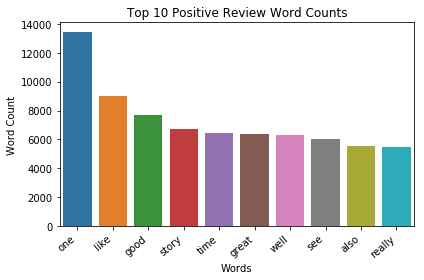

In [99]:
print('Most Frequently Used Words in Positive Reviews:\n')
for i in range(10):
    print(pos_sorted[i])
    
# plot top 10 word counts bar chart
pos_words = []
pos_counts = []
for word, count in pos_sorted[:10]:
    pos_words.append(word)
    pos_counts.append(count)
pos_wc = sns.barplot(pos_words, pos_counts)
pos_wc.set_title('Top 10 Positive Review Word Counts')
pos_wc.set(xlabel = 'Words', ylabel = 'Word Count')
pos_wc.set_xticklabels(pos_wc.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Most Frequently Used Words in Negative Reviews:

('one', 12968)
('like', 11195)
('even', 7641)
('good', 7371)
('bad', 7338)
('would', 6898)
('really', 6240)
('time', 6160)
('see', 5425)
('story', 5167)


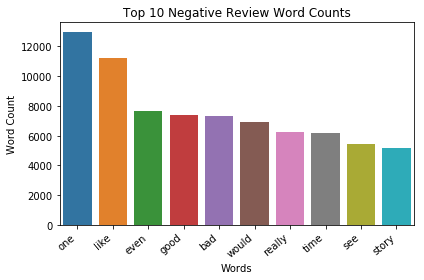

In [98]:
print('Most Frequently Used Words in Negative Reviews:\n')
for i in range(10):
    print(neg_sorted[i])
    
# plot top 10 word counts bar chart
neg_words = []
neg_counts = []
for word, count in neg_sorted[:10]:
    neg_words.append(word)
    neg_counts.append(count)
neg_wc = sns.barplot(neg_words, neg_counts)
neg_wc.set_title('Top 10 Negative Review Word Counts')
neg_wc.set(xlabel = 'Words', ylabel = 'Word Count')
neg_wc.set_xticklabels(neg_wc.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [102]:
neg_words = set(neg_words)
pos_words = set(pos_words)
print('Top Words in Positive Top 10 but not in Negative Top 10:', pos_words.difference(neg_words))
print('Top Words in Negative Top 10 but not in Positive Top 10:', neg_words.difference(pos_words))

Top Words in Positive Top 10 but not in Negative Top 10: {'also', 'great', 'well'}
Top Words in Negative Top 10 but not in Positive Top 10: {'even', 'bad', 'would'}


After plotting the top ten most frequent words in both positive and negative reviews, it can be seen that positive and negative reviews share most of the top ten words found in the datasets. However, it can be noted that the words they differ on, do not add much sentiment with the exception of "great" and "bad". The word "great" is one of positive reviews' and not one of negative reviews' top ten words; on the other hand, the word "bad" appears in negative reviews' top ten most common words and not in positive reviews'. Both of those make sense as "great" has a greater positive connotation, and the word "bad" has a greater negative connotation. Next we will explore the top words found only in either positive or negative reviews but not both.

#### *2. Exclusive Word Document Counts*
Below we will see what the most common words appearing exclusively in either positive or negative reviews are. Words will be counted once per review, meaning that if a word is used more than once in a review, only the first instance of the word will be counted.

In [74]:
# sort positive reviews' word document counts from most to least frequent
pos_sorted_once = sorted(pos.word_docs.items(), key=operator.itemgetter(1), reverse=True)
# create a set of positive document words
positive_words_once = set([word for word, counts in pos_sorted_once])

# sort negative reviews' word document counts from most to least frequent
neg_sorted_once = sorted(neg.word_docs.items(), key=operator.itemgetter(1), reverse=True)
# create a set of negative document words
negative_words_once = set([word for word, counts in neg_sorted_once])

In [75]:
# document words found in positive reviews but not in negative reviews
only_positive_once = []
for word, count in pos_sorted_once:
    if word in positive_words_once.difference(negative_words_once):
        only_positive_once.append((word, count))
# sort words by document count
only_positive_once.sort(key=operator.itemgetter(1), reverse=True)

# words found in negative reviews but not in positive reviews
only_negative_once = []
for word, count in neg_sorted_once:
    if word in negative_words_once.difference(positive_words_once):
        only_negative_once.append((word, count))
# sort words by count
only_negative_once.sort(key=operator.itemgetter(1), reverse=True)

10 Most Frequent Positive Only Words (Counted Once per Review):

('edie', 40)
('3000', 4)
('too', 4)
('43', 3)
('2500', 3)
('iamaseal2', 3)
('hotmailcom', 3)
('rating13', 3)
('wonderland', 3)
('92', 2)


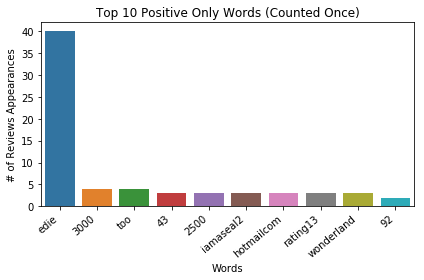

In [79]:
print('10 Most Frequent Positive Only Words (Counted Once per Review):\n')
for i in range(10):
    print(only_positive_once[i])
    
# plot positive word document count as bar chart
pos_words_once_plt = []
pos_counts_once_plt = []
for word, count in only_positive_once[:10]:
    pos_words_once_plt.append(word)
    pos_counts_once_plt.append(count)
pos_once_bar = sns.barplot(pos_words_once_plt, pos_counts_once_plt)
pos_once_bar.set_title('Top 10 Positive Only Words (Counted Once)')
pos_once_bar.set(xlabel = 'Words', ylabel = '# of Reviews Appearances')
pos_once_bar.set_xticklabels(pos_once_bar.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

10 Most Frequent Negative Only Words (Counted Once per Review):

('300', 7)
('250000', 7)
('wasn', 5)
('950', 5)
('8p', 5)
('couldn', 5)
('gasp', 5)
('they', 5)
('700', 4)
('bulls', 4)


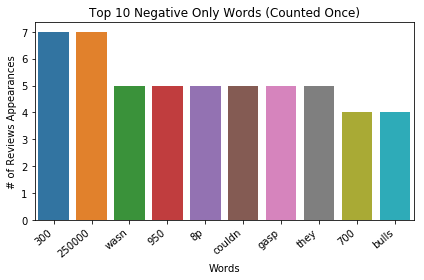

In [80]:
print('10 Most Frequent Negative Only Words (Counted Once per Review):\n')
for i in range(10):
    print(only_negative_once[i])
    
# negative word document count bar chart
neg_words_once_plt = []
neg_counts_once_plt = []
for word, count in only_negative_once[:10]:
    neg_words_once_plt.append(word)
    neg_counts_once_plt.append(count)
neg_once_bar = sns.barplot(neg_words_once_plt, neg_counts_once_plt)
neg_once_bar.set_title('Top 10 Negative Only Words (Counted Once)')
neg_once_bar.set(xlabel = 'Words', ylabel = '# of Reviews Appearances')
neg_once_bar.set_xticklabels(neg_once_bar.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

After counting the top words appearing exclusively in either positive or negative reviews, it can be noted that the top ten most common words in each type of review do not seem to add any form of sentiment to the review. This further supports our idea that we will have to use kera's embedding layer to account for the context of words, given that the most frequent unique words found only in either positive or negative reviews do not add any sentiment information to the review. Also, the word "edie" appears more than normal in positive reviews, we are going to look at some reviews in the next section to see how "edie" is being used in positive reviews.

#### *3. "edie"?*
In this section we will see what edie refers to. Is edie an actor?

In [96]:
# find all reviews where edie is mentioned
edie_reviews = []
for review in positive_reviews:
    if 'edie' in set(review.split()):
        edie_reviews.append(review)

In [157]:
# example edie in review
print('sample review containing "edie":\n\n', edie_reviews[3])

sample review containing "edie":

 find intriguing lee jackie sister cousin women would make big edie little edie subject certainly could considered family closet extra features dvd include several contemporary fashion ideas women id say anyone interested fashion would find discussion fascinating ie missing something hard come though


It turns out that most of the reviews containing "edie" in the review are referring to a highly rated 1975 movie called *Grey Gardens*. The word "edie" will not generalize much when training the deep learning model, since it corresponds to a single movie. Therefore, it does not add much additional information if the model is tested on another movie other than *Grey Gardens*. However, I will leave it in the training set, since the same movie might appear in the any future test review, in which it could aid the classification of that particular review. 

#### *4. Polarizing Word Counts*
Below we will explore word counts of each type of review regarding highly sentimental words, or polarizing.

Positive Reviews' Polar Word Counts:

love : 4270
awesome : 359
hate : 344
boring : 329
exciting : 300
horrible : 154

-------------------

Negative Reviews' Polar Word Counts:

love : 2126
boring : 1457
horrible : 1038
hate : 445
exciting : 206
awesome : 118


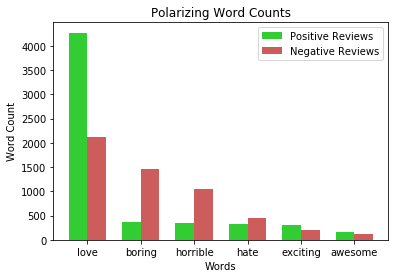

In [103]:
polar_set = set(['hate', 'love', 'awesome', 'horrible', 'boring', 'exciting'])
polar_pos = []
polar_neg = []
print("Positive Reviews' Polar Word Counts:\n")
for word, count in pos_sorted:
    if word in polar_set:
        polar_pos.append(count)
        print(word, ':', count)
print("\n-------------------\n\nNegative Reviews' Polar Word Counts:\n")
for word, count in neg_sorted:
    if word  in polar_set:
        polar_neg.append(count)
        print(word, ':', count)
        
        # plot polarizing word counts
N = 6
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, polar_pos, width, label='Positive Reviews', color='limegreen')
plt.bar(ind + width, polar_neg, width,
    label='Negative Reviews', color='indianred')

plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Polarizing Word Counts')

plt.xticks(ind + width / 2, ('love', 'boring', 'horrible', 'hate', 'exciting', 'awesome'))
plt.legend(loc='best')
plt.show()

As it can be seen, even though words exclusively found in either positive or negative reviews don't contain any valuable sentiment, a pattern can be seen in the word counts of words rich in sentiment connotation. Words with positive connotations have way higher word counts in positive reviews and vice versa. For example, the word "love", even though it shows up in both types of reviews, it can be seen that the word "love" appears more than twice as frequent in positive reviews than it does in negative reviews. Therefore, word context is still really important, but it turns out that words by themselves will prove useful when training the deep learning model to better understand the difference between positive and negative reviews.